In [1]:
# agentEnv.py - Agent environment
# AIFCA Python3 code Version 0.7.7 Documentation at http://aipython.org

# Artificial Intelligence: Foundations of Computational Agents
# http://artint.info
# Copyright David L Poole and Alan K Mackworth 2017.
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# See: http://creativecommons.org/licenses/by-nc-sa/4.0/deed.en

import math
from agents import Environment

class Rob_env(Environment):
    def __init__(self,walls = {}):
        """walls is a set of line segments 
               where each line segment is of the form ((x0,y0),(x1,y1))
        """
        self.walls = walls
        
import math
from agents import Environment
import matplotlib.pyplot as plt
import time

class Rob_body(Environment):
    def __init__(self, env, init_pos=(0,0,90)):
        """ env is the current environment
        init_pos is a triple of (x-position, y-position, direction) 
            direction is in degrees; 0 is to right, 90 is straight-up, etc
        """
        self.env = env
        self.rob_x, self.rob_y, self.rob_dir = init_pos
        self.turning_angle = 18   # degrees that a left makes
        self.whisker_length = 6   # length of the whisker
        self.whisker_angle = 30   # angle of whisker relative to robot
        self.crashed = False
        # The following control how it is plotted
        self.plotting = True      # whether the trace is being plotted
        self.sleep_time = 0.05     # time between actions (for real-time plotting)
        # The following are data structures maintained:
        self.history = [(self.rob_x, self.rob_y)] # history of (x,y) positions
        self.wall_history = []     # history of hitting the wall

    def percepts(self):
        return {'rob_x_pos':self.rob_x, 'rob_y_pos':self.rob_y,
                'rob_dir':self.rob_dir, 'whisker':self.whisker() , 'crashed':self.crashed}
    initial_percepts = percepts  # use percept function for initial percepts too

    def do(self,action):
        """ action is {'steer':direction}
        direction is 'left', 'right' or 'straight'
        """
        if self.crashed:
            return self.percepts()
        direction = action['steer']  
        compass_deriv = {'left':1,'straight':0,'right':-1}[direction]*self.turning_angle
        self.rob_dir = (self.rob_dir + compass_deriv +360)%360  # make in range [0,360)
        rob_x_new = self.rob_x + math.cos(self.rob_dir*math.pi/180)
        rob_y_new = self.rob_y + math.sin(self.rob_dir*math.pi/180)
        path = ((self.rob_x,self.rob_y),(rob_x_new,rob_y_new))
        if any(line_segments_intersect(path,wall) for wall in self.env.walls):
            self.crashed = True
            if self.plotting:
                plt.plot([self.rob_x],[self.rob_y],"r*",markersize=20.0)
                plt.draw()
        self.rob_x, self.rob_y = rob_x_new, rob_y_new 
        self.history.append((self.rob_x, self.rob_y))
        if self.plotting and not self.crashed:
            plt.plot([self.rob_x],[self.rob_y],"go")
            plt.draw()
            plt.pause(self.sleep_time)
        return self.percepts()

    def whisker(self):
        """returns true whenever the whisker sensor intersects with a wall
        """
        whisk_ang_world = (self.rob_dir-self.whisker_angle)*math.pi/180
            # angle in radians in world coordinates
        wx = self.rob_x + self.whisker_length * math.cos(whisk_ang_world)
        wy = self.rob_y + self.whisker_length * math.sin(whisk_ang_world)
        whisker_line = ((self.rob_x,self.rob_y),(wx,wy))
        hit = any(line_segments_intersect(whisker_line,wall)
                    for wall in self.env.walls)
        if hit:
            self.wall_history.append((self.rob_x, self.rob_y))
            if self.plotting:
                plt.plot([self.rob_x],[self.rob_y],"ro")
                plt.draw()
        return hit
    
def line_segments_intersect(linea,lineb):
    """returns true if the line segments, linea and lineb intersect.
    A line segment is represented as a pair of points.
    A point is represented as a (x,y) pair.
    """
    ((x0a,y0a),(x1a,y1a)) = linea
    ((x0b,y0b),(x1b,y1b)) = lineb
    da, db = x1a-x0a, x1b-x0b
    ea, eb = y1a-y0a, y1b-y0b
    denom = db*ea-eb*da
    if denom==0:    # line segments are parallel
        return False
    cb = (da*(y0b-y0a)-ea*(x0b-x0a))/denom  # position along line b
    if cb<0 or cb>1:
        return False
    ca = (db*(y0b-y0a)-eb*(x0b-x0a))/denom # position along line a
    return 0<=ca<=1

# Test cases:
# assert line_segments_intersect(((0,0),(1,1)),((1,0),(0,1)))
# assert not line_segments_intersect(((0,0),(1,1)),((1,0),(0.6,0.4)))
# assert line_segments_intersect(((0,0),(1,1)),((1,0),(0.4,0.6)))



In [2]:
# agentMiddle.py - Middle Layer
# AIFCA Python3 code Version 0.7.7 Documentation at http://aipython.org

# Artificial Intelligence: Foundations of Computational Agents
# http://artint.info
# Copyright David L Poole and Alan K Mackworth 2017.
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# See: http://creativecommons.org/licenses/by-nc-sa/4.0/deed.en

from agents import Environment
import math

class Rob_middle_layer(Environment):
    def __init__(self,env):
        self.env=env
        self.percepts = env.initial_percepts()
        self.straight_angle = 11 # angle that is close enough to straight ahead
        self.close_threshold = 2  # distance that is close enough to arrived
        self.close_threshold_squared = self.close_threshold**2 # just compute it once

    def initial_percepts(self):
        return {}

    def do(self, action):
        """action is {'go_to':target_pos,'timeout':timeout}
        target_pos is (x,y) pair
        timeout is the number of steps to try
        returns {'arrived':True} when arrived is true
             or {'arrived':False} if it reached the timeout 
        """
        if 'timeout' in action:
            remaining = action['timeout']
        else:
            remaining = -1    # will never reach 0
        target_pos = action['go_to']
        arrived = self.close_enough(target_pos)
        while not arrived and remaining != 0:
            self.percepts = self.env.do({"steer":self.steer(target_pos)})
            remaining -= 1
            arrived = self.close_enough(target_pos)
        return {'arrived':arrived}

    def steer(self,target_pos):
        if self.percepts['whisker']:
            self.display(3,'whisker on', self.percepts)
            return "left"
        else:
            gx,gy = target_pos
            rx,ry = self.percepts['rob_x_pos'],self.percepts['rob_y_pos']
            goal_dir = math.acos((gx-rx)/math.sqrt((gx-rx)*(gx-rx)
                                                   +(gy-ry)*(gy-ry)))*180/math.pi
            if ry>gy:
                goal_dir = -goal_dir
            goal_from_rob = (goal_dir - self.percepts['rob_dir']+540)%360-180
            assert -180 < goal_from_rob <= 180
            if goal_from_rob > self.straight_angle:
                return "left"
            elif goal_from_rob < -self.straight_angle:
                return "right"
            else:
                return "straight"

    def close_enough(self,target_pos):
        gx,gy = target_pos
        rx,ry = self.percepts['rob_x_pos'],self.percepts['rob_y_pos']
        return (gx-rx)**2 + (gy-ry)**2 <= self.close_threshold_squared


    

In [3]:
# agentTop.py - Top Layer
# AIFCA Python3 code Version 0.7.7 Documentation at http://aipython.org

# Artificial Intelligence: Foundations of Computational Agents
# http://artint.info
# Copyright David L Poole and Alan K Mackworth 2017.
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# See: http://creativecommons.org/licenses/by-nc-sa/4.0/deed.en

from agentMiddle import Rob_middle_layer
from agents import Environment

class Rob_top_layer(Environment):
    def __init__(self, middle, timeout=200, locations = {'mail':(-5,10), 
                          'o103':(50,10), 'o109':(100,10),'storage':(101,51)} ):
        """middle is the middle layer
        timeout is the number of steps the middle layer goes before giving up
        locations is a loc:pos dictionary 
            where loc is a named location, and pos is an (x,y) position.
        """
        self.middle = middle
        self.timeout = timeout  # number of steps before the middle layer should give up
        self.locations = locations
        
    def do(self,plan):
        """carry out actions.
        actions is of the form {'visit':list_of_locations}
        It visits the locations in turn.
        """
        to_do = plan['visit']
        for loc in to_do:
            position = self.locations[loc]
            arrived = self.middle.do({'go_to':position, 'timeout':self.timeout})
            self.display(1,"Arrived at",loc,arrived)

import matplotlib.pyplot as plt

class Plot_env(object):
    def __init__(self, body,top):
        """sets up the plot
        """
        self.body = body
        plt.ion()
        plt.clf()
        plt.axes().set_aspect('equal')
        for wall in body.env.walls:
            ((x0,y0),(x1,y1)) = wall
            plt.plot([x0,x1],[y0,y1],"-k",linewidth=3)
        for loc in top.locations:
            (x,y) = top.locations[loc]
            plt.plot([x],[y],"k<")
            plt.text(x+1.0,y+0.5,loc) # print the label above and to the right
        plt.plot([body.rob_x],[body.rob_y],"go")
        plt.draw()

    def plot_run(self):
        """plots the history after the agent has finished.
        This is typically only used if body.plotting==False
        """
        xs,ys = zip(*self.body.history)
        plt.plot(xs,ys,"go")
        wxs,wys = zip(*self.body.wall_history)
        plt.plot(wxs,wys,"ro")
        #plt.draw()

from agentEnv import Rob_body, Rob_env

env = Rob_env({((20,0),(30,20)), ((70,-5),(70,25))})
body = Rob_body(env)
middle = Rob_middle_layer(body)
top = Rob_top_layer(middle)

# try:
# pl=Plot_env(body,top)
# top.do({'visit':['o109','storage','o109','o103']})
# You can directly control the middle layer:
# middle.do({'go_to':(30,-10), 'timeout':200})
# Can you make it crash?

# Robot Trap for which the current controller cannot escape:
trap_env = Rob_env({((10,-21),(10,0)), ((10,10),(10,31)), ((30,-10),(30,0)),
                    ((30,10),(30,20)),  ((50,-21),(50,31)), ((10,-21),(50,-21)),
                    ((10,0),(30,0)),  ((10,10),(30,10)),  ((10,31),(50,31))})
trap_body = Rob_body(trap_env,init_pos=(-1,0,90))
trap_middle = Rob_middle_layer(trap_body)
trap_top = Rob_top_layer(trap_middle,locations={'goal':(71,0)})

# Robot trap exercise:
# pl=Plot_env(trap_body,trap_top)
# trap_top.do({'visit':['goal']})



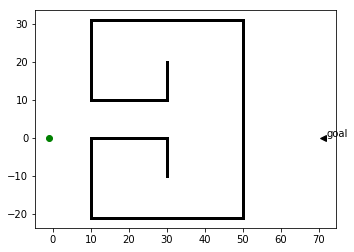

In [4]:
pl=Plot_env(trap_body,trap_top)

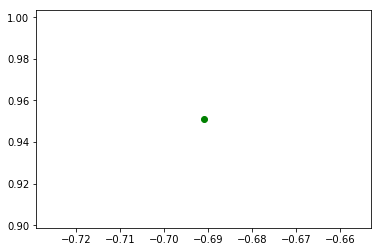

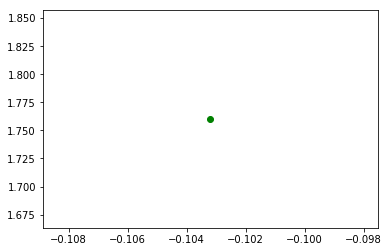

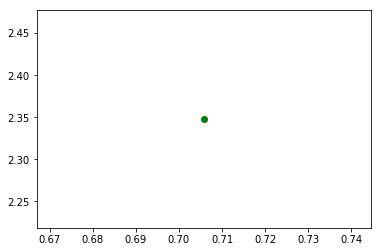

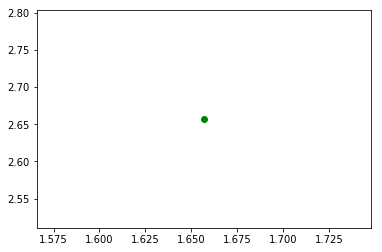

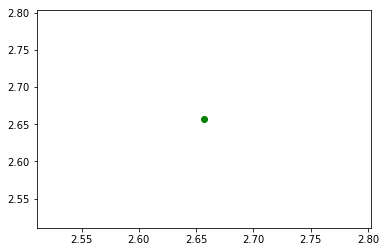

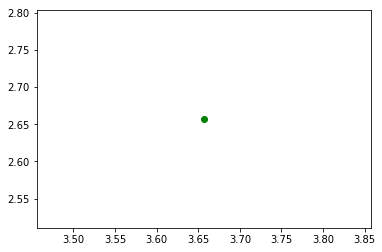

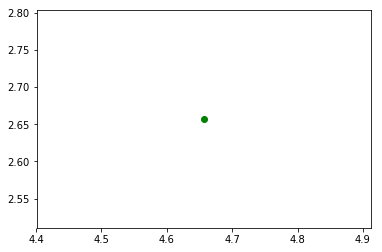

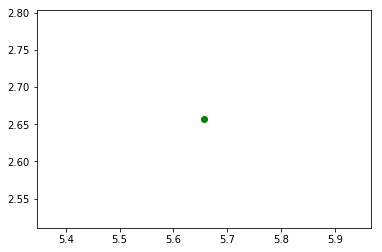

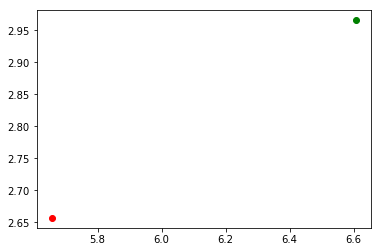

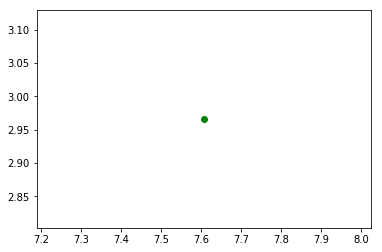

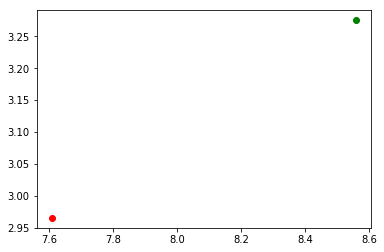

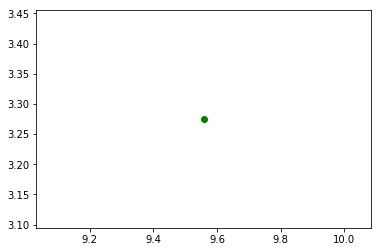

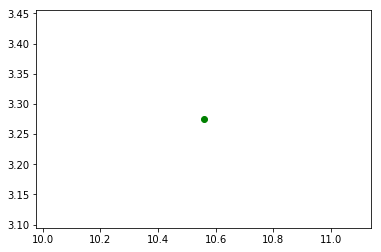

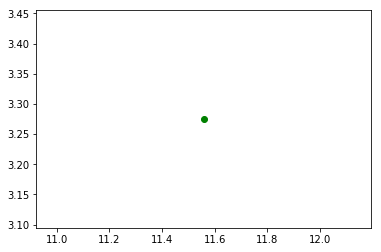

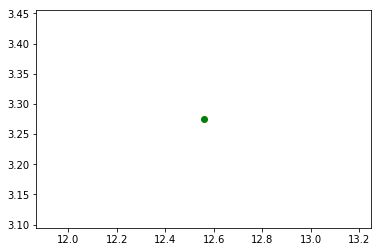

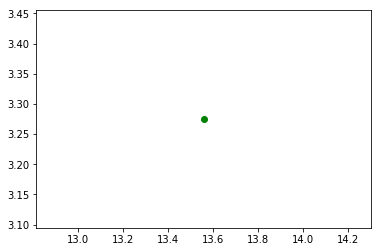

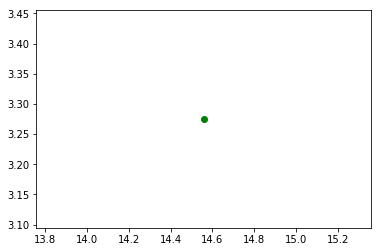

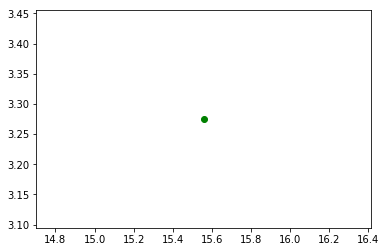

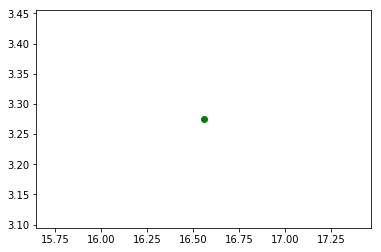

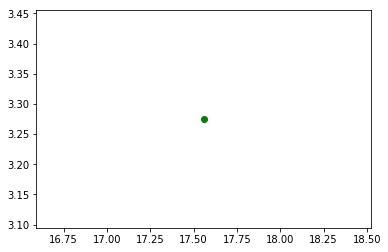

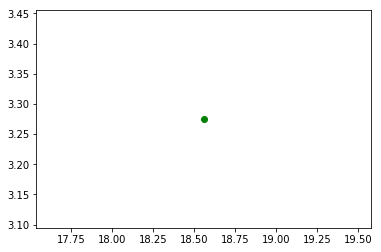

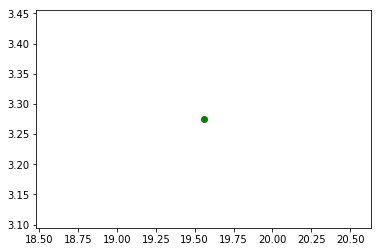

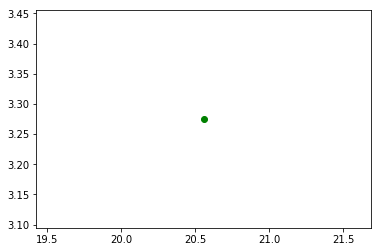

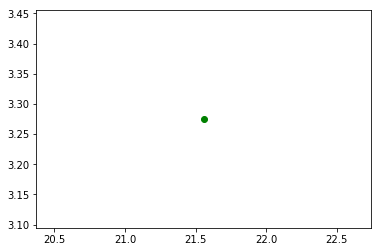

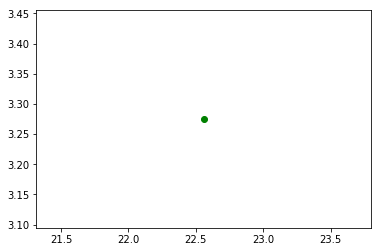

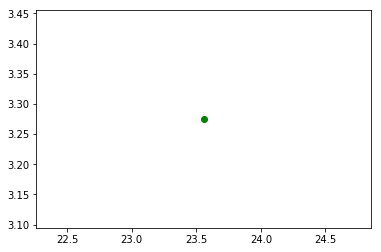

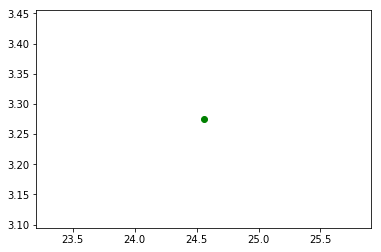

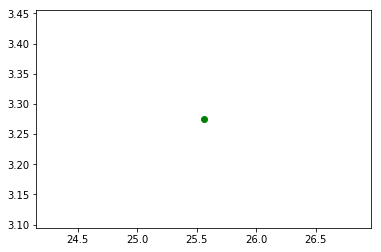

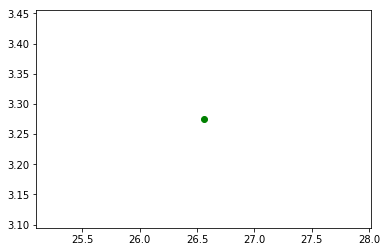

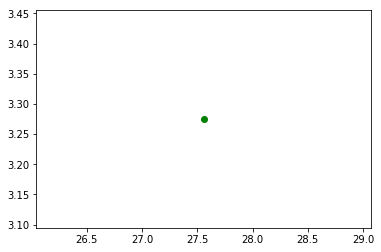

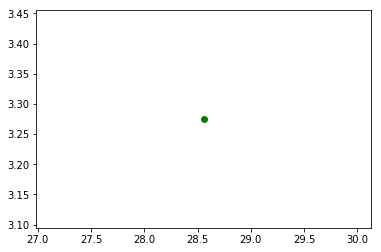

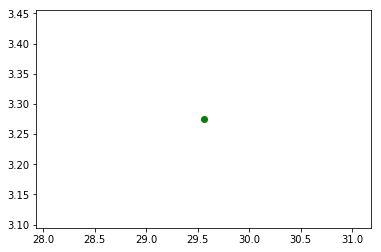

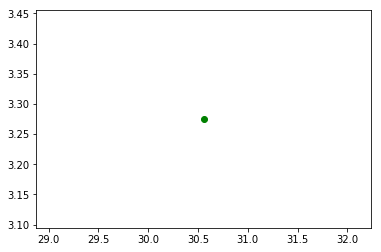

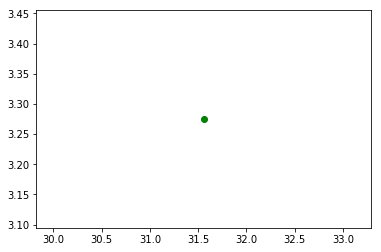

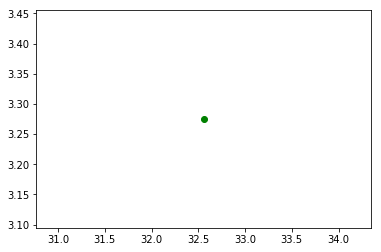

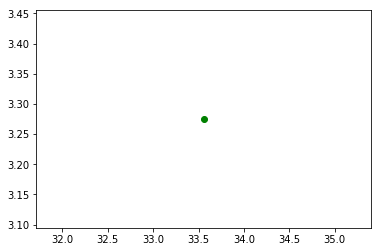

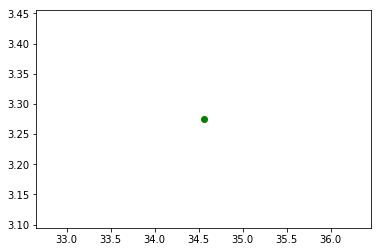

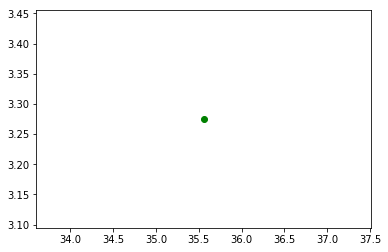

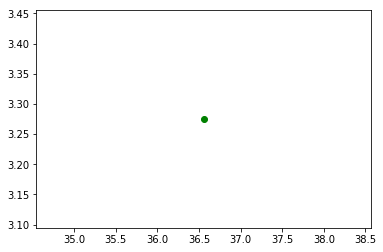

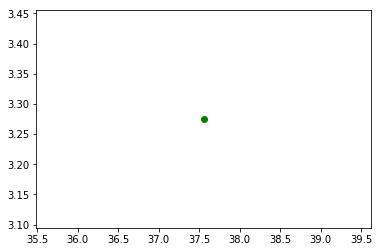

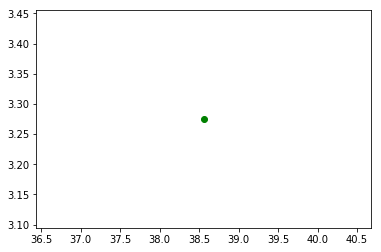

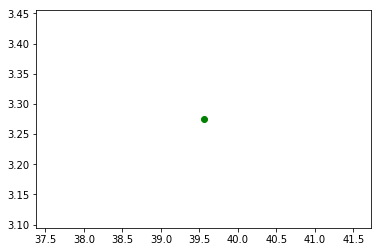

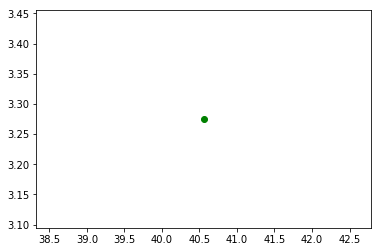

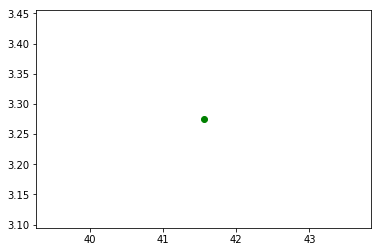

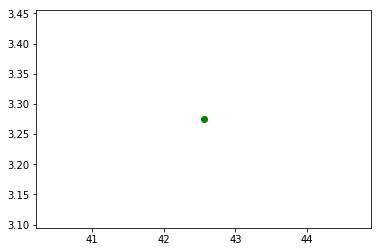

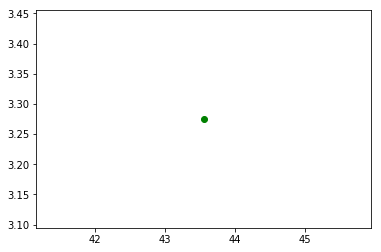

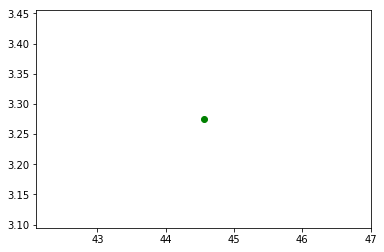

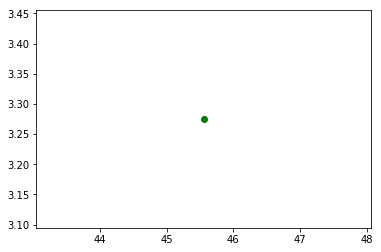

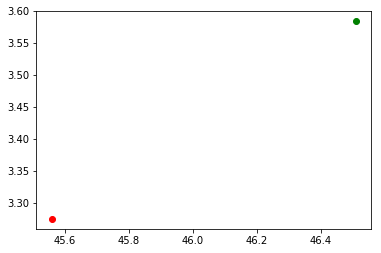

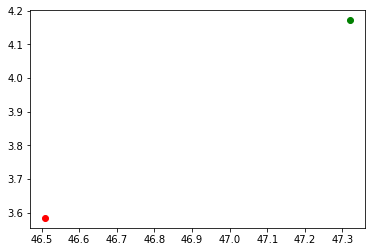

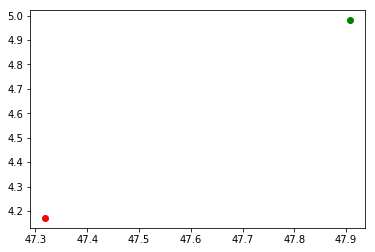

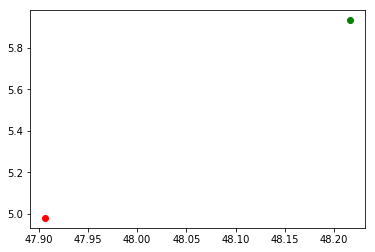

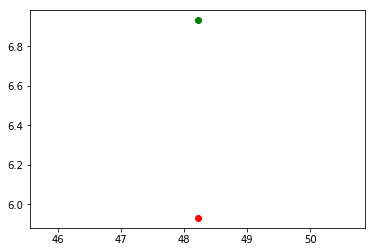

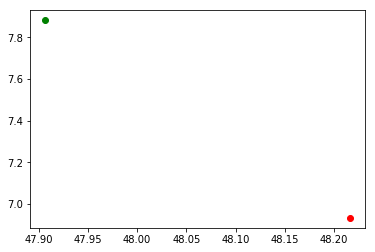

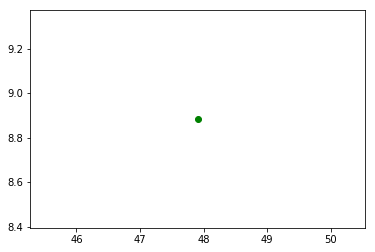

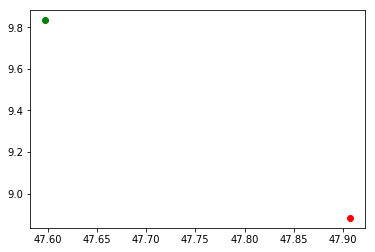

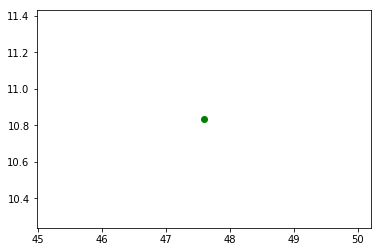

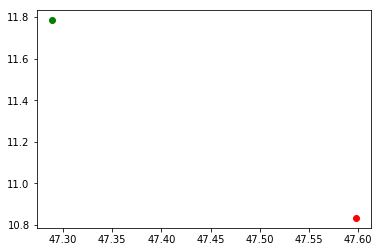

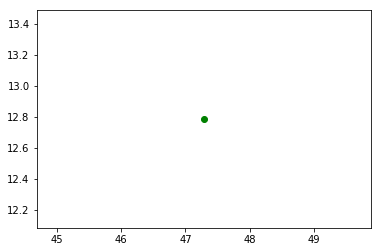

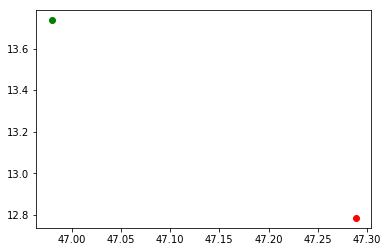

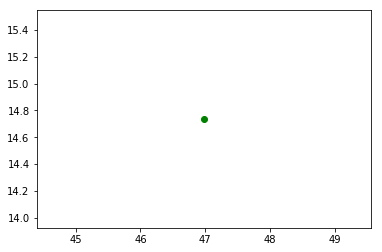

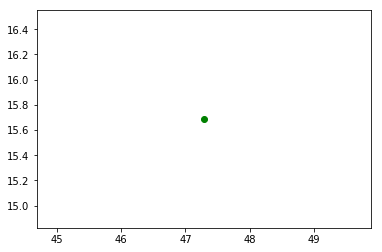

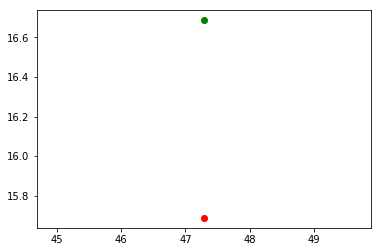

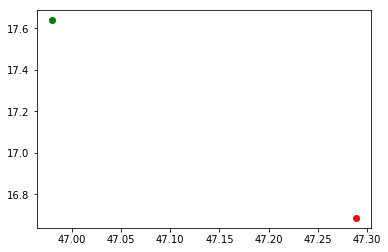

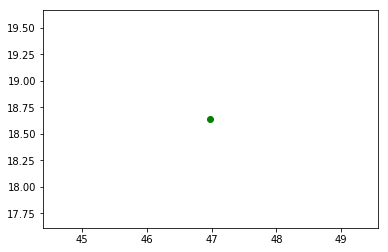

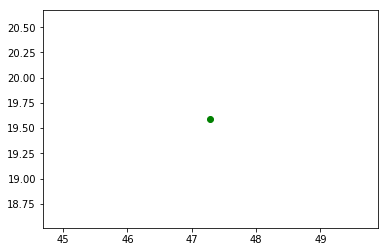

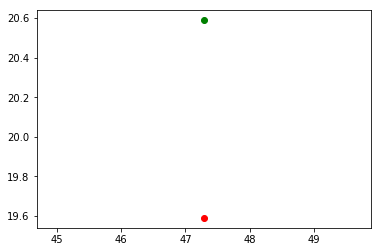

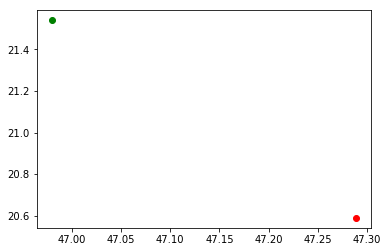

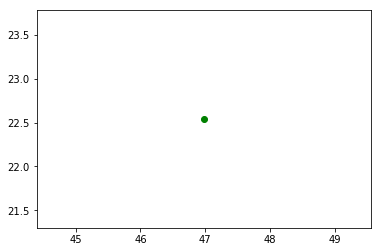

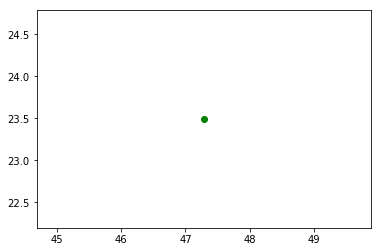

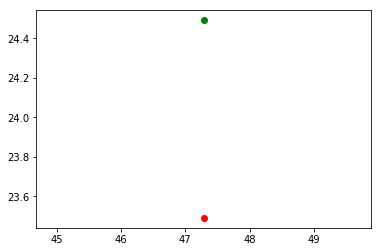

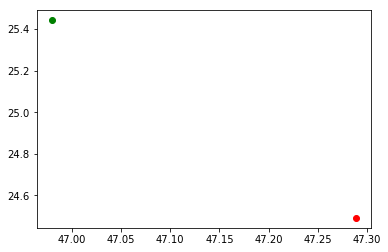

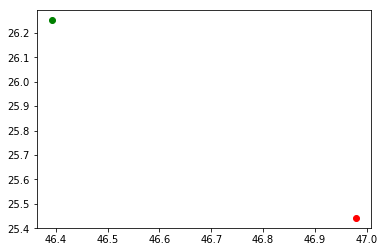

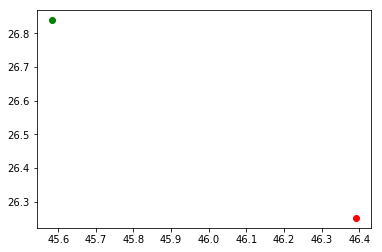

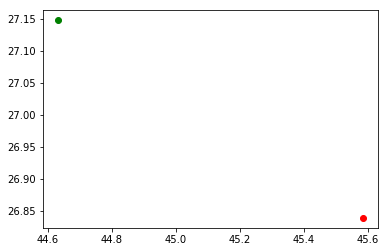

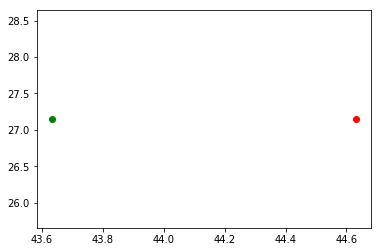

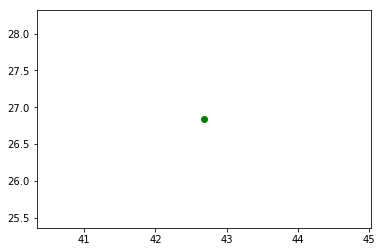

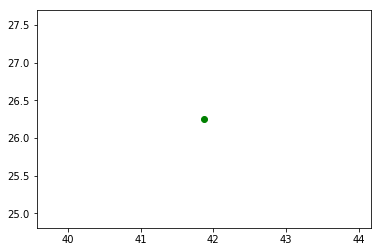

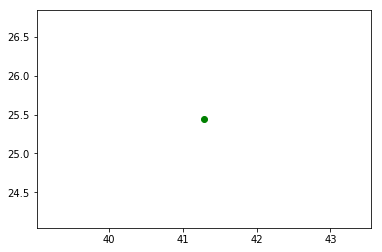

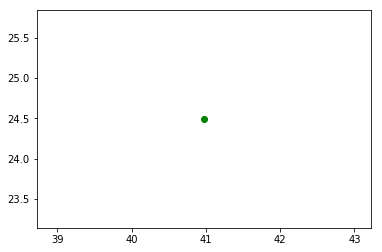

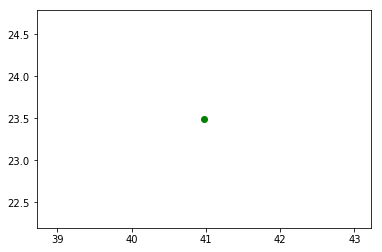

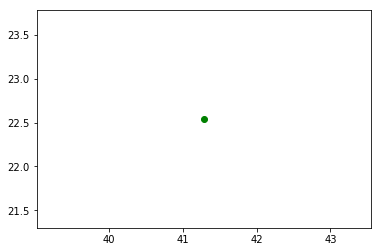

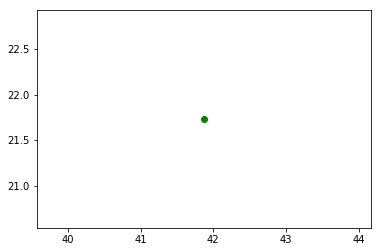

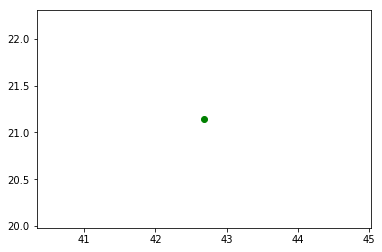

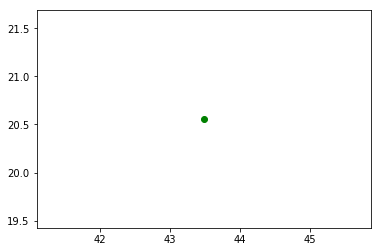

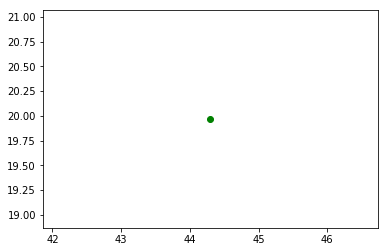

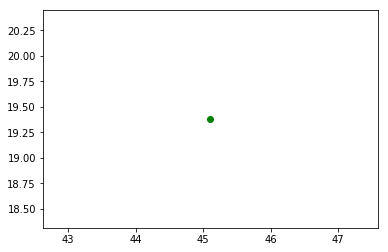

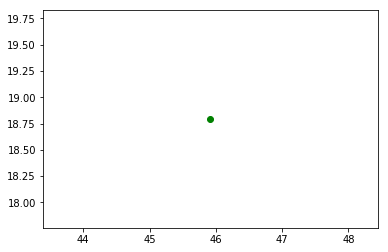

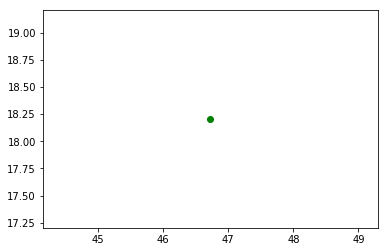

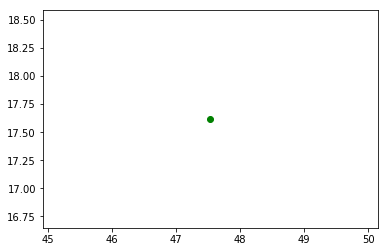

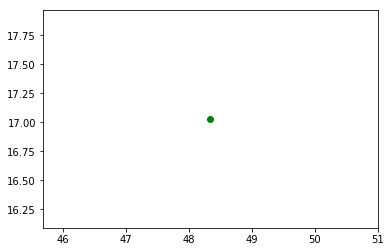

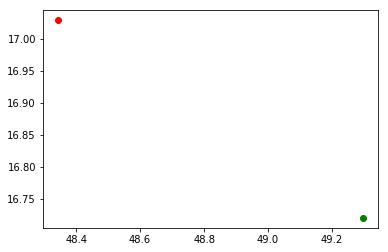

Arrived at goal {'arrived': False}


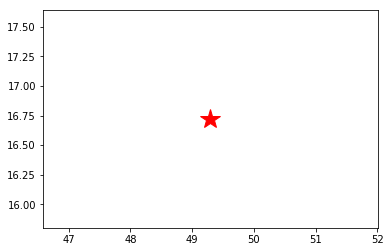

In [5]:
trap_top.do({'visit':['goal']})

In [6]:



#### Partying Decision Example ####
import random #Adding a utility function

def argmax(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmax returns an element with maximal value.
    If there are multiple elements with the max value, one is returned at random.
    """
    maxv = float('-Infinity')       # negative infinity
    maxvals = []      # list of maximal elements
    for (e,v) in gen:
        if v>maxv:
            maxvals,maxv = [e], v
        elif v==maxv:
            maxvals.append(e)
    return random.choice(maxvals)

# Try:
# argmax(enumerate([1,6,3,77,3,55,23]))

def flip(prob):
    """return true with probability prob"""
    return random.random() < prob

def dict_union(d1,d2):
    """returns a dictionary that contains the keys of d1 and d2.
    The value for each key that is in d2 is the value from d2,
    otherwise it is the value from d1.
    This does not have side effects.
    """
    d = dict(d1)    # copy d1
    d.update(d2)
    return d

def test():
    """Test part of utilities"""
    assert argmax(enumerate([1,6,55,3,55,23])) in [2,4]
    assert dict_union({1:4, 2:5, 3:4},{5:7, 2:9}) == {1:4, 2:9, 3:4, 5:7} 
    print("Passed unit test in utilities")

if __name__ == "__main__":
    test()


class MDP(object):#A clas for markovian decision processes
    def __init__(self, states, actions, trans, reward, discount):
        """states is a list or tuple of states.
        actions is a list or tuple of actions
        trans[s][a][s'] represents P(s'|a,s)
        reward[s][a] gives the expected reward of doing a in state s
        discount is a real in the range [0,1]
        """
        self.states = states
        self.actions = actions
        self.trans = trans
        self.reward = reward
        self.discount = discount
        self.v0 = [0 for s in states]  # initial value function
        
    def vi1(self,v):
         """carry out one iteration of value iteration and 
         returns a value function (a list of a value for each state).
         v is the previous value function.
         """
         return [max([self.reward[s][a]+self.discount*product(self.trans[s][a],v)
                      for a in range(len(self.actions))])
                 for s in range(len(self.states))]

    def vi(self,v0,n):
        """carries out n iterations of value iteration starting with value v0.

        Returns a value function
        """
        val = self.v0
        for i in range(n):
           val= self.vi1(val)
        return val

    def policy(self,v): 
         """returns an optimal policy assuming the next value function is v
            v is a list of values for each state
            returns a list of the indexes of optimal actions for each state
         """
         return [argmax(enumerate([self.reward[s][a]+self.discount*product(self.trans[s][a],v)
                                   for a in range(len(self.actions))]))
                 for s in range(len(self.states))]

    def q(self,v): 
        """returns the one-step-lookahead q-value assuming the next value function is v
        v is a list of values for each state
        returns a list of q values for each state. so that q[s][a] represents Q(s,a)
        """
        return [[self.reward[s][a]+self.discount*product(self.trans[s][a],v)
                  for a in range(len(self.actions))]
                 for s in range(len(self.states))]
    
def product(l1,l2):
    """returns the dot product of l1 and l2"""
    return sum([i1*i2 for (i1,i2) in zip(l1,l2)])



# States: Healthy Sick
# Actions: Relax Party

# trans[s][a][s'] gives P(s'|a,s)
#           Relax        Party
trans2 = (((0.95,0.05), (0.7, 0.3)),   # Healthy
          ((0.5,0.5),   (0.1, 0.9))    # Sick
        )

# reward[s][a] gives the expected reward of doing a in state s.
reward2 = ((7,10),(0,2))

healthy2 = MDP(['Healthy','Sick'], ['Relax','Party'], trans2, reward2, discount=0.8) 

## Tiny Game from Example 11.7 and Figure 11.8 of Poole and Mackworth, 2010 #

# actions        up                right          upC             left
transt = (((0.1,0.1,0.8,0,0,0), (0,1,0,0,0,0), (0,0,1,0,0,0), (1,0,0,0,0,0)), #s0
         ((0.1,0.1,0,0.8,0,0), (0,1,0,0,0,0), (0,0,0,1,0,0), (1,0,0,0,0,0)),  #s1
         ((0,0,0.1,0.1,0.8,0), (0,0,0,1,0,0), (0,0,0,0,1,0), (0,0,1,0,0,0)),  #s2
         ((0,0,0.1,0.1,0,0.8), (0,0,0,1,0,0), (0,0,0,0,0,1), (0,0,1,0,0,0)),  #s3
         ((0.1,0,0,0,0.8,0.1), (0,0,0,0,0,1), (0,0,0,0,1,0), (1,0,0,0,0,0)),  #s4
         ((0,0,0,0,0.1,0.9),   (0,0,0,0,0,1), (0,0,0,0,0,1), (0,0,0,0,1,0)) ) #s5

# actions     up  rt  upC  left
rewardt = ((-0.1,  0,  -1,   -1),   #s0
           (-0.1, -1,  -2,    0),   #s1
           (-10,   0,  -1, -100),   #s2
           (-0.1, -1,  -1,    0),   #s3
           (-1,    0,  -2,   10),   #s4
           (-1,   -1,  -2,    0))   #s5

mdpt = MDP(['s0','s1','s2','s3','s4','s5'],   # states
           ['up', 'right', 'upC', 'left'],    # actions
           transt, rewardt, discount=0.9)

def trace(mdp,numiter):
    print("Q values are shown as",[[st+"_"+ac for ac in mdp.actions] for st in mdp.states])
    print("One step lookahead Q-values:")
    print(mdp.q(mdp.v0))
    print("Values are for the states:", mdp.states)
    print("One step lookahead values:")
    print(mdp.vi(mdp.v0,1))
    print("Two step lookahead Q-values:")
    print(mdp.q(mdp.vi(mdp.v0,1)))
    print("Two step lookahead values:")
    print(mdp.vi(mdp.v0,2))
    vfin = mdp.vi(mdp.v0,numiter)
    print("After",numiter,"iterations, values:")
    print(vfin)
    print("After",numiter,"iterations, Q-values:")
    print(mdp.q(vfin))
    print("After",numiter,"iterations, Policy:", 
           [st+"->"+mdp.actions[act] for (st,act) in zip(mdp.states ,mdp.policy(vfin))])

# Try the following:
# trace(healthy2,10)



Passed unit test in utilities


In [7]:
trace(healthy2,10)


Q values are shown as [['Healthy_Relax', 'Healthy_Party'], ['Sick_Relax', 'Sick_Party']]
One step lookahead Q-values:
[[7.0, 10.0], [0.0, 2.0]]
Values are for the states: ['Healthy', 'Sick']
One step lookahead values:
[10.0, 2.0]
Two step lookahead Q-values:
[[14.68, 16.08], [4.800000000000001, 4.24]]
Two step lookahead values:
[16.08, 4.800000000000001]
After 10 iterations, values:
[32.45950570966077, 20.554744073232058]
After 10 iterations, Q-values:
[[32.49141410227146, 33.11046177498572], [21.205699913157133, 19.396176189499943]]
After 10 iterations, Policy: ['Healthy->Party', 'Sick->Relax']


In [8]:
# decnNetworks.py - Representations for Decision Networks
# AIFCA Python3 code Version 0.7.7 Documentation at http://aipython.org

# Artificial Intelligence: Foundations of Computational Agents
# http://artint.info
# Copyright David L Poole and Alan K Mackworth 2017.
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# See: http://creativecommons.org/licenses/by-nc-sa/4.0/deed.en

from probGraphicalModels import Graphical_model
from probFactors import Factor_stored
from probVariables import Variable
from probFactors import Prob


#Describe a utility function
class Utility(Factor_stored):
    """A factor defined by a utility"""
    def __init__(self,vars,table):
        """Creates a factor on vars from the table.
        The table is ordered according to vars.
        """
        Factor_stored.__init__(self,vars,table)
        assert self.size==len(table),"Table size incorrect "+str(self)

class DecisionVariable(Variable):
    def __init__(self,name,domain,parents):
        Variable.__init__(self,name,domain)
        self.parents = parents
        self.all_vars = set(parents) | {self}

class DecisionNetwork(Graphical_model):
    def __init__(self,vars=None,factors=None):
        """vars is a list of variables
        factors is a list of factors (instances of Prob and Utility)
        """
        Graphical_model.__init__(self,vars,factors)

from probFactors import factor_times, Factor_stored
from probVE import VE

#Perform variables elimination
class VE_DN(VE):
    """Variable Elimination for Decision Networks"""
    def __init__(self,dn=None):
        """dn is a decision network"""
        VE.__init__(self,dn)
        self.dn = dn
        
    def optimize(self,elim_order=None,obs={}):
        if elim_order == None:
                elim_order = self.gm.variables
        policy = []
        proj_factors = [self.project_observations(fact,obs) 
                           for fact in self.dn.factors]
        for v in elim_order:
            if isinstance(v,DecisionVariable):
                to_max = [fac for fac in proj_factors
                          if v in fac.variables and set(fac.variables) <= v.all_vars]
                assert len(to_max)==1, "illegal variable order "+str(elim_order)+" at "+str(v)
                newFac = Factor_max(v, to_max[0])
                policy.append(newFac.decision_fun)
                proj_factors = [fac for fac in proj_factors if fac is not to_max[0]]+[newFac]
                self.display(2,"maximizing",v,"resulting factor",newFac.brief() )
                self.display(3,newFac)
            else:
                proj_factors = self.eliminate_var(proj_factors, v)
        assert len(proj_factors)==1,"Should there be only one element of proj_factors?"
        value = proj_factors[0].get_value({})
        return value,policy

class Factor_max(Factor_stored):
    """A factor obtained by maximizing a variable in a factor.
    Also builds a decision_function. This is based on Factor_sum.
    """

    def __init__(self, dvar, factor):
        """dvar is a decision variable. 
        factor is a factor that contains dvar and only parents of dvar
        """
        self.dvar = dvar
        self.factor = factor
        vars = [v for v in factor.variables if v is not dvar]
        Factor_stored.__init__(self,vars,None)
        self.values = [None]*self.size
        self.decision_fun = Factor_DF(dvar,vars,[None]*self.size)

    def get_value(self,assignment):
        """lazy implementation: if saved, return saved value, else compute it"""
        index = self.assignment_to_index(assignment)
        if self.values[index]:
            return self.values[index]
        else:
            max_val = float("-inf")  # -infinity
            new_asst = assignment.copy()
            for elt in self.dvar.domain:
                new_asst[self.dvar] = elt
                fac_val = self.factor.get_value(new_asst)
                if fac_val>max_val:
                    max_val = fac_val
                    best_elt = elt
            self.values[index] = max_val
            self.decision_fun.values[index] = best_elt
            return max_val
           
class Factor_DF(Factor_stored):
    """A decision function"""
    def __init__(self,dvar, vars, values):
        Factor_stored.__init__(self,vars,values)
        self.dvar = dvar
        self.name = str(dvar)  # Used in printing

boolean = [False, True]
Al = Variable("Alarm", boolean)
Fi = Variable("Fire", boolean)
Le = Variable("Leaving", boolean)
Re = Variable("Report", boolean)
Sm = Variable("Smoke", boolean)
Ta = Variable("Tamper", boolean)
SS = Variable("See Sm", boolean)
CS = DecisionVariable("Ch Sm", boolean,{Re})
Call = DecisionVariable("Call", boolean,{SS,CS,Re})

f_ta = Prob(Ta,[],[0.98,0.02])
f_fi = Prob(Fi,[],[0.99,0.01])
f_sm = Prob(Sm,[Fi],[0.99,0.01,0.1,0.9])
f_al = Prob(Al,[Fi,Ta],[0.9999, 0.0001, 0.15, 0.85, 0.01, 0.99, 0.5, 0.5])
f_lv = Prob(Le,[Al],[0.999, 0.001, 0.12, 0.88])
f_re = Prob(Re,[Le],[0.99, 0.01, 0.25, 0.75])
f_ss = Prob(SS,[CS,Sm],[1,0,1,0,1,0,0,1])

ut = Utility([CS,Fi,Call],[0,-200,-5000,-200,-20,-220,-5020,-220])

dnf = DecisionNetwork([Ta,Fi,Al,Le,Sm,Call,SS,CS,Re],[f_ta,f_fi,f_sm,f_al,f_lv,f_re,f_ss,ut])
# v,p = VE_DN(dnf).optimize()
# for df in p: print(df,"\n")

grades = ["A","B","C","F"]
Wa = Variable("Watched", boolean)
CC1 = Variable("Caught1", boolean)
CC2 = Variable("Caught2", boolean)
Pun = Variable("Punish",["None","Suspension","Recorded"])
Gr1 = Variable("Grade_1",grades)
Gr2 = Variable("Grade_2",grades)
GrF = Variable("Fin_Grd",grades)
Ch1 = DecisionVariable("Cheat_1", boolean,set())  #no parents
Ch2 = DecisionVariable("Cheat_2", boolean,{Ch1,CC1})

p_wa = Prob(Wa,[],[0.7, 0.3])
p_cc1 = Prob(CC1,[Wa,Ch1],[1.0, 0.0, 0.9, 0.1, 1.0, 0.0, 0.5, 0.5])
p_cc2 = Prob(CC2,[Wa,Ch2],[1.0, 0.0, 0.9, 0.1, 1.0, 0.0, 0.5, 0.5])
p_pun = Prob(Pun,[CC1,CC2],[1.0, 0.0, 0.0, 0.5, 0.4, 0.1, 0.6, 0.2, 0.2, 0.2, 0.5, 0.3])
p_gr1 = Prob(Gr1,[Ch1], [0.2, 0.3, 0.3, 0.2, 0.5, 0.3, 0.2, 0.0])
p_gr2 = Prob(Gr2,[Ch2], [0.2, 0.3, 0.3, 0.2, 0.5, 0.25, 0.25, 0.0])
p_fg = Prob(GrF,[Gr1,Gr2],
        [1.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.25, 0.5, 0.25, 0.0, 0.25,
        0.25, 0.25, 0.25, 0.5, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5,
        0.5, 0.0, 0.0, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.0, 0.0, 0.5, 0.5,
        0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.25, 0.75, 0.25, 0.5, 0.25, 0.0,
        0.0, 0.25, 0.5, 0.25, 0.0, 0.0, 0.25, 0.75, 0.0, 0.0, 0.0, 1.0])
utc = Utility([Pun,GrF],[100,90,70,50,40,20,10,0,70,60,40,20])

cheat_dn = DecisionNetwork([Pun,CC2,Wa,GrF,Gr2,Gr1,Ch2,CC1,Ch1],
                      [p_wa, p_cc1, p_cc2, p_pun, p_gr1, p_gr2,p_fg,utc])

# VE_DN.max_display_level = 3  # if you want to show lots of detail
# v,p = VE_DN(cheat_dn).optimize(); print(v)
# for df in p: print(df,"\n") # print decision functions



In [9]:
VE_DN.max_display_level = 3  # if you want to show lots of detail

In [10]:
v,p = VE_DN(cheat_dn).optimize(); print(v)

eliminating  Punish
Multiplying: ['f26(Caught1,Caught2,Punish)', 'f30(Punish,Fin_Grd)']
Creating factor: f31(Caught1,Caught2,Fin_Grd)
Caught1	Caught2	Fin_Grd	f31
False	False	A	100.0
False	False	B	90.0
False	False	C	70.0
False	False	F	50.0
False	True	A	73.0
False	True	B	59.0
False	True	C	43.0
False	True	F	27.0
True	False	A	82.0
True	False	B	70.0
True	False	C	52.0
True	False	F	34.0
True	True	A	61.0
True	True	B	46.0
True	True	C	31.0
True	True	F	16.0

eliminating  Caught2
Multiplying: ['f25(Watched,Cheat_2,Caught2)', 'f31(Caught1,Caught2,Fin_Grd)']
Creating factor: f32(Watched,Cheat_2,Caught1,Fin_Grd)
Watched	Cheat_2	Caught1	Fin_Grd	f32
False	False	False	A	100.0
False	False	False	B	90.0
False	False	False	C	70.0
False	False	False	F	50.0
False	False	True	A	82.0
False	False	True	B	70.0
False	False	True	C	52.0
False	False	True	F	34.0
False	True	False	A	97.3
False	True	False	B	86.9
False	True	False	C	67.3
False	True	False	F	47.7
False	True	True	A	79.89999999999999
False	True	True	B	67.6
False	T